In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
X = np.load("digits_X.npy")
y = np.load("digits_y.npy")

In [3]:
X.shape

(2062, 64, 64)

In [4]:
X = np.concatenate((X[204:409], X[822:1028]), axis=0)
z = np.zeros(409 - 204)
o = np.ones(1028 - 822)
y = np.concatenate((z, o), axis=0).reshape(X.shape[0], 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=333
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(328, 64, 64)
(328, 1)
(83, 64, 64)
(83, 1)


In [6]:
X_train_flat = X_train.reshape(
    X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_flat = X_test.reshape(
    X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print(X_train_flat.shape)
print(X_test_flat.shape)


(328, 4096)
(83, 4096)


In [7]:
def initialize_parameters(seed=392, dimension=4096, hidden_layer_size=3):
    np.random.seed(seed)

    # n neurons less than the previous layer
    n = 2
    parameters = {
        "weights1": np.random.rand(dimension, hidden_layer_size)
        # Use np.random.rand(dim1,dim2)*0.01, inputing the correct dimensions
        * 0.01,
        "bias1": np.zeros(
            (1, hidden_layer_size)
        ),  # Use np.zeros(shape), inputing the correct shape
        "weights2": np.random.randn(hidden_layer_size, hidden_layer_size - n)
        # Use np.random.randn(dim1,dim2)*0.01, inputing the correct dimensions
        * 0.01,
        "bias2": np.zeros((1, hidden_layer_size - n)),
        "weights3": np.random.randn(hidden_layer_size - n, 1)
        # Use np.random.randn(dim1,dim2)*0.01, inputing the correct dimensions
        * 0.01,
        "bias3": np.zeros((1, 1)),
    }  # Use np.zeros(shape), inputing the correct shape
    return parameters


In [8]:
def relu(z):
    return np.maximum(
        0, z
    )  # for proper vectorization, you might want to look up `np.maximum`


def sigma(z):
    return 1 / (1 + np.exp(-z))  # you have seen this before in logistic regression

In [9]:
def forward_propagation_naive(X, y, parameters, hidden_layer_size):

    # Layer 1 (hidden layer)
    # doing the dot computation
    Z1 = np.zeros((X.shape[0], hidden_layer_size))
    A1 = np.zeros((X.shape[0], hidden_layer_size))
    for neuron in range(hidden_layer_size):
        w = parameters["weights1"][
            :, neuron
        ]  # find the right weight (recall that we stacked our weights with shape (in,out))
        b = parameters["bias1"][
            0, neuron
        ]  # find the right bias term (recall that we stacked our biases with shape (1,out))
        z = (
            np.dot(X, w) + b
        )  # compute z, using np.dot. Think of the correct dimensions!
        Z1[:, neuron] = z
        A1[:, neuron] = relu(z)

    # Layer 2 (output layer)
    Z2 = (
        np.dot(A1, parameters["weights2"]) + parameters["bias2"]
    )  # at the second layer, there is only one node. Use np.dot again, and watch out for the correct dimensions
    A2 = relu(Z2)

    # Layer 3 (output layer)
    Z3 = (
        np.dot(A2, parameters["weights3"]) + parameters["bias3"]
    )  # at the third layer, there is only one node. Use np.dot again, and watch out for the correct dimensions
    A3 = sigma(Z3)

    # Compute the cost
    yHat = A3
    cost = np.sum(-y * np.log(yHat) - (1 - y) * np.log(1 - yHat)) / X.shape[0]

    # Compute the cache
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2,
        "Z3": Z3,
        "A3": A3,
    }

    return cost, cache

## Adding one more layer 

In [10]:
def forward_propagation(X, y, parameters):
    # Layer 1 (hidden layer)
    Z1 = np.dot(X, parameters["weights1"]) + parameters["bias1"]  # Use np.dot!
    A1 = relu(Z1)

    # Layer 2 (output layer)
    Z2 = np.dot(A1, parameters["weights2"]) + parameters["bias2"]  # Use np.dot!
    A2 = relu(Z2)

    # Layer 3 (output layer)
    Z3 = np.dot(A2, parameters["weights3"]) + parameters["bias3"]  # Use np.dot!
    A3 = sigma(Z3)

    # Compute the cost - this is exactly as before!
    yHat = A3
    cost = np.sum(-y * np.log(yHat) - (1 - y) * np.log(1 - yHat)) / X.shape[0]

    # Compute the cache
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}

    return cost, cache

In [11]:
parameters = initialize_parameters(seed=333, dimension=4096, hidden_layer_size=4)
cost, _ = forward_propagation(X_train_flat, y_train, parameters)
print(cost)

0.693146839074952


## Adding one more layer 

But using sigma to be the activation function for all layers

In [12]:
def back_propagation(X, y, parameters, cache):
    dZ3 = (cache["A3"] - y) / X.shape[0]
    dW3 = np.dot(cache["A2"].T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    # dZ2 = (cache["A2"] - y) / X.shape[0]
    # dW2 = np.dot(cache["A1"].T, dZ2)
    # db2 = np.sum(dZ2, axis=0, keepdims=True)

    # dZ1 = (cache["A1"] - y) / X.shape[0]
    # dW1 = np.dot(X.T, dZ1)
    # db1 = np.sum(dZ1, axis=0, keepdims=True)

    dZ2 = np.dot(dZ3, parameters["weights3"].T) * np.where(cache["Z2"] > 0, 1, 0)
    dW2 = np.dot(cache["A1"].T, dZ3)
    db2 = np.sum(
        dZ2, axis=0, keepdims=True
    )  # make sure to sum up over the right axis (see the np.sum documentation), and to set keepdims=True

   
    dZ1 = np.dot(dZ2, parameters["weights2"].T) * np.where(cache["Z1"] > 0, 1, 0)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(
        dZ1, axis=0, keepdims=True
    ) 
    grads = {
        "weights1": dW1,
        "bias1": db1,
        "weights2": dW2,
        "bias2": db2,
        "weights3": dW3,
        "bias3": db3,
    }
    return grads


In [13]:
def parameter_update(X, y, parameters, learning_rate):
    cost, cache = forward_propagation(X, y, parameters)
    grads = back_propagation(X, y, parameters, cache)
    for entry in parameters:
        parameters[entry] = parameters[entry] - learning_rate * grads[entry]
    return parameters, cost

# Training the model with two hidden layers which has 4 and 2 neurons respectively
# Iterating the optimatisation process 10000 times 
# Decreasing the learning rate to 0.0095

In [14]:
def model_training(
    X, y, hidden_layer_size=4, learning_rate=0.0095, iterations=10000, verbose=True
):
    parameters = initialize_parameters(
        seed=np.random.randint(1),
        dimension=X.shape[1],
        hidden_layer_size=hidden_layer_size,
    )  # Initialize the parameters
    cost_list = []
    for it in range(iterations):
        parameters, cost = parameter_update(
            X, y, parameters, learning_rate
        )  # for each iteration, update the parameters using forward and back propagation
        cost_list.append(cost)  # Also, make sure to add the cost to the cost_list
        if verbose:
            print("Cost after iteration %i: %f" % (it, cost))
    return parameters, cost_list

In [15]:
parameters, cost_list = model_training(X_train_flat, y_train)

Cost after iteration 0: 0.693124
Cost after iteration 1: 0.693135
Cost after iteration 2: 0.693142
Cost after iteration 3: 0.693138
Cost after iteration 4: 0.693135
Cost after iteration 5: 0.693132
Cost after iteration 6: 0.693128
Cost after iteration 7: 0.693125
Cost after iteration 8: 0.693122
Cost after iteration 9: 0.693119
Cost after iteration 10: 0.693116
Cost after iteration 11: 0.693113
Cost after iteration 12: 0.693110
Cost after iteration 13: 0.693107
Cost after iteration 14: 0.693104
Cost after iteration 15: 0.693101
Cost after iteration 16: 0.693098
Cost after iteration 17: 0.693095
Cost after iteration 18: 0.693092
Cost after iteration 19: 0.693089
Cost after iteration 20: 0.693087
Cost after iteration 21: 0.693084
Cost after iteration 22: 0.693081
Cost after iteration 23: 0.693078
Cost after iteration 24: 0.693075
Cost after iteration 25: 0.693072
Cost after iteration 26: 0.693069
Cost after iteration 27: 0.693067
Cost after iteration 28: 0.693064
Cost after iteration 29:

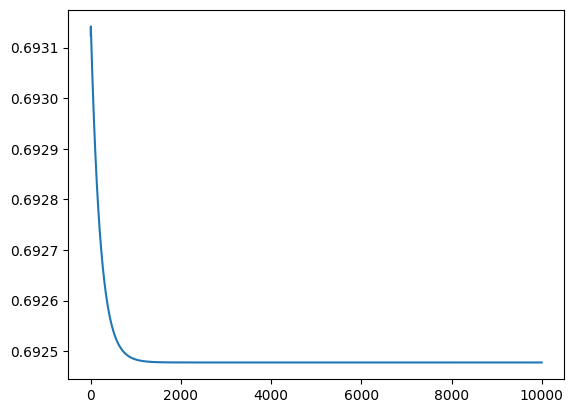

In [16]:
plt.plot(range(len(cost_list)), cost_list)
plt.show()

## Get the yHat from A3

In [17]:
def predict(X, parameters):
    _, cache = forward_propagation(X, np.zeros((X.shape[0], 1)), parameters)
    yHat = cache["A3"]  # Get yHat from the cache
    y_prediction = (
        yHat > 0.5
    )  # Make a prediction - when yHat > 0.5, assume 1, otherwise 0
    return y_prediction

## The result for accuracy has a very tiny increase 

In [18]:
y_prediction_test = predict(X_test_flat, parameters)
y_prediction_train = predict(X_train_flat, parameters)

print(
    "train accuracy: {} %".format(
        100 - np.mean(np.abs(y_prediction_train - y_train)) * 100
    )
)
print(
    "test accuracy: {} %".format(
        100 - np.mean(np.abs(y_prediction_test - y_test)) * 100
    )
)


train accuracy: 51.829268292682926 %
test accuracy: 42.168674698795186 %


## Percentage of improvement compared with the accuracy in the tutorial is 1.224

In [19]:
96.3855421686747 - 95.16129032258064

1.224251846094063